In [1]:
import warnings
warnings.filterwarnings('ignore')

# Tiny VGG

In [2]:
import torch 
from torch import nn

class Tiny_VGG(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2),
        )

        self.block_3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
        )

        self.block_4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2),
        )

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=1690, out_features= n_classes)
        )
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.fc(x)
        return x

In [3]:
import json
def custom_cnn(class_names: None|list = None, pretrain_model_path: None|str= None, device: str= 'cpu'):
    info_data = None
    if pretrain_model_path is None:
        model = Tiny_VGG(len(class_names)).to(device)

    else:
        pretrain_model_path = Path(pretrain_model_path)

        with open(pretrain_model_path / 'info.json', 'r') as f:
            info_data = json.load(f)
        
        model = Tiny_VGG(len(class_names)).to(device)
        model.load_state_dict(torch.load(f=pretrain_model_path / 'model.pth'))
        model = model.to(device)
        
    return model, info_data

In [4]:
# %%writefile model/train.py
import torch
from torch import nn
from torchvision import transforms

from pathlib import Path
from torchmetrics import Accuracy, ConfusionMatrix

from model.data_setup import create_dataloader
from model.engine import train
from model.utils import save_model
from model.model_builder import resnet50_model
from model.model_builder import resnet18_model
from model.model_builder import efficientnet_b3_model

def run(**kwargs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    print(f"Device: '{device}'")
    
    train_transforms_data = transforms.Compose([
        transforms.RandomResizedCrop(size=(64, 64), antialias=True),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
        transforms.transforms.ColorJitter(brightness= [0.9, 1.1], contrast= [0.9, 1.1]),
        transforms.ToTensor(),
        transforms.Normalize((0.4522, 0.4627, 0.4181), (0.1883, 0.166, 0.202)),
    ])
    
    val_transforms_data = transforms.Compose([
        transforms.Resize(size= 64),
        transforms.ToTensor(),
        transforms.Normalize((0.4522, 0.4627, 0.4181), (0.1883, 0.166, 0.202)),
    ])

    test_transforms_data = transforms.Compose([
        transforms.Resize(size= 64),
        transforms.ToTensor(),
        transforms.Normalize((0.4522, 0.4627, 0.4181), (0.1883, 0.166, 0.202)),
    ])
    
    train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloader(train_transform=train_transforms_data,
                                                                                      val_transform=val_transforms_data,
                                                                                      test_transform=test_transforms_data,
                                                                                      **kwargs)


    model, info_data = custom_cnn(class_names= class_names, pretrain_model_path= kwargs['train_para']['pretrain_model_path'], device= device)
    
    loss_func = nn.CrossEntropyLoss()

    lr = kwargs['train_para']['optimize']['learning_rate']
    momentum = kwargs['train_para']['optimize']['momentum']
    weight_decay = kwargs['train_para']['optimize']['weight_decay']
    optimizer = torch.optim.SGD(params= model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    # optimizer = torch.optim.Adam(params= model.parameters(), lr= kwargs['train_para']['learning_rate'], weight_decay= 0.0001)
    
    accur = Accuracy(task='multiclass', num_classes= len(class_names)).to(device)

    step_size = kwargs['train_para']['lr_scheduler']['step_size']
    gamma = kwargs['train_para']['lr_scheduler']['gamma']
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size= step_size,
        gamma= gamma
    )

    epochs= kwargs['train_para']['epochs']
    save_checkpoint_freq= kwargs['train_para']['save_checkpoint_freq']
    verbose= kwargs['train_para']['verbose']
    
    results = train(
            model= model,
            train_dataloader= train_dataloader,
            val_dataloader= val_dataloader,
            test_dataloader= test_dataloader,
            loss_func= loss_func,
            optimizer= optimizer,
            lr_scheduler= lr_scheduler,
            mectric_funcs= accur,
            epochs= epochs,
            info_data = info_data,
            save_checkpoint_freq= save_checkpoint_freq,
            verbose= verbose,
            device= device,
    )
    
    save_model(model= model, results= results, class_names= class_names, device= device, **kwargs)

Device: 'cuda'
Epoch:  1 | Train Loss: 2.21461 | Train Acc: 16.8536 | Val Loss: 2.00958 | Val Acc: 28.7202
Epoch:  2 | Train Loss: 1.81853 | Train Acc: 34.6802 | Val Loss: 1.44318 | Val Acc: 46.7262
Epoch:  3 | Train Loss: 1.47389 | Train Acc: 47.8810 | Val Loss: 1.39595 | Val Acc: 54.3155
Epoch:  4 | Train Loss: 1.40065 | Train Acc: 50.8544 | Val Loss: 1.31780 | Val Acc: 50.5456
Epoch:  5 | Train Loss: 1.28113 | Train Acc: 55.6823 | Val Loss: 1.18303 | Val Acc: 58.4821
Epoch:  6 | Train Loss: 1.20076 | Train Acc: 58.9802 | Val Loss: 0.97531 | Val Acc: 68.6508
Epoch:  7 | Train Loss: 1.12564 | Train Acc: 61.6464 | Val Loss: 0.94233 | Val Acc: 67.0635
Epoch:  8 | Train Loss: 1.09246 | Train Acc: 62.1835 | Val Loss: 0.79284 | Val Acc: 72.5198
Epoch:  9 | Train Loss: 0.98961 | Train Acc: 66.3327 | Val Loss: 0.74617 | Val Acc: 74.1567
Epoch: 10 | Train Loss: 0.96514 | Train Acc: 66.6222 | Val Loss: 0.79365 | Val Acc: 73.2143
Epoch: 11 | Train Loss: 0.89310 | Train Acc: 69.4452 | Val Loss: 

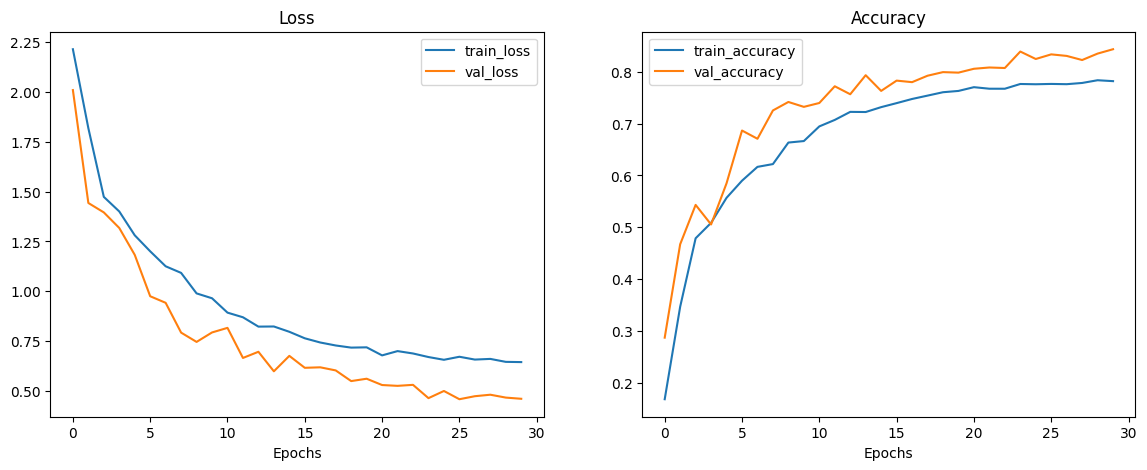

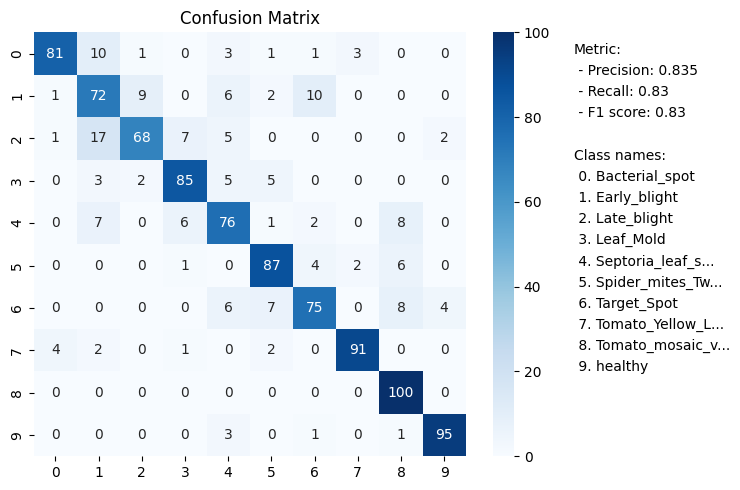

In [5]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'dataset_path':'./datasets/tomato',
            'folder_train': 'train',
            'folder_val': 'val',    
            'folder_test': 'test',
            'batch_size': 32,
        },
        'train_para': {
            'pretrain_model_path': None,
            'epochs': 30,
            'optimize' : {
                'learning_rate': 0.01,
                'momentum': 0.9,
                'weight_decay': 0.00001,
            },
            'lr_scheduler' : {
                'step_size' : 2,
                'gamma' : 0.75,
            },
            'save_checkpoint_freq' : 0,
            'verbose': False
        },
        'save_para': {
            'model_name': 'model.pth',
            'graph_loss_name': 'loss_acc.jpg',
            'graph_confmat_name': 'confusion_matrix.jpg',
            'info_file_name': 'info.json'
        }
    }

    # train.run(**config)
    run(**config)

# Resnet-18

In [1]:
import torch 
from torch import nn

class BasicBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: list[int, int, int], stride: list[int, int, int], is_downsample: bool):
        super().__init__()

        self.is_downsample = is_downsample
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size[0], stride=stride[0], padding=(1, 1), bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size[1], stride=stride[1], padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        if is_downsample:
            self.downsample= nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size[2], stride=stride[2], bias=True),
                nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.is_downsample:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [2]:
import torch 
from torch import nn

class Resnet_model(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            BasicBlock(in_channels= 64, out_channels= 64, kernel_size= [3, 3, 0], stride= [1, 1, 0], is_downsample= False),
            BasicBlock(in_channels= 64, out_channels= 64, kernel_size= [3, 3, 0], stride= [1, 1, 0], is_downsample= False),
        )

        self.layer2 = nn.Sequential(
            BasicBlock(in_channels= 64, out_channels= 128, kernel_size= [3, 3, 1], stride= [2, 1, 2], is_downsample= True),
            BasicBlock(in_channels= 128, out_channels= 128, kernel_size= [3, 3, 0], stride= [1, 1, 0], is_downsample= False),
        )

        self.layer3 = nn.Sequential(
            BasicBlock(in_channels= 128, out_channels= 256, kernel_size= [3, 3, 1], stride= [2, 1, 2], is_downsample= True),
            BasicBlock(in_channels= 256, out_channels= 256, kernel_size= [3, 3, 0], stride= [1, 1, 0], is_downsample= False),
        )

        self.layer4 = nn.Sequential(
            BasicBlock(in_channels= 256, out_channels= 512, kernel_size= [3, 3, 1], stride= [2, 1, 2], is_downsample= True),
            BasicBlock(in_channels= 512, out_channels= 512, kernel_size= [3, 3, 0], stride= [1, 1, 0], is_downsample= False),
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

        self.fc = nn.Sequential(
            nn.Linear(in_features=512, out_features=n_classes, bias=True)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [3]:
import json
def custom_cnn(class_names: None|list = None, pretrain_model_path: None|str= None, device: str= 'cpu'):
    info_data = None
    if pretrain_model_path is None:
        model = Resnet_model(len(class_names)).to(device)

    else:
        pretrain_model_path = Path(pretrain_model_path)

        with open(pretrain_model_path / 'info.json', 'r') as f:
            info_data = json.load(f)
        
        model = Resnet_model(len(class_names)).to(device)
        model.load_state_dict(torch.load(f=pretrain_model_path / 'model.pth'))
        model = model.to(device)
        
    return model, info_data

# Training

In [4]:
# %%writefile model/train.py
import torch
from torch import nn
from torchvision import transforms

from pathlib import Path
from torchmetrics import Accuracy, ConfusionMatrix

from model.data_setup import create_dataloader
from model.engine import train, test
from model.utils import plot_save_model
from model.model_builder import resnet50_model
from model.model_builder import resnet18_model
from model.model_builder import efficientnet_b3_model

def run(**kwargs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    print(f"Device: '{device}'")
    
    train_transforms_data = transforms.Compose([
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
        transforms.transforms.ColorJitter(brightness= [0.9, 1.1], contrast= [0.9, 1.1]),
        transforms.ToTensor(),
        transforms.Normalize((0.4522, 0.4627, 0.4181), (0.1883, 0.166, 0.202)),
    ])
    
    val_transforms_data = transforms.Compose([
        transforms.Resize(size= 224),
        transforms.ToTensor(),
        transforms.Normalize((0.4522, 0.4627, 0.4181), (0.1883, 0.166, 0.202)),
    ])

    test_transforms_data = transforms.Compose([
        transforms.Resize(size= 224),
        transforms.ToTensor(),
        transforms.Normalize((0.4522, 0.4627, 0.4181), (0.1883, 0.166, 0.202)),
    ])
    
    train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloader(train_transform=train_transforms_data,
                                                                                      val_transform=val_transforms_data,
                                                                                      test_transform=test_transforms_data,
                                                                                      **kwargs)


    model, info_data = custom_cnn(class_names= class_names, pretrain_model_path= kwargs['train_para']['pretrain_model_path'], device= device)
    
    loss_func = nn.CrossEntropyLoss()

    lr = kwargs['train_para']['optimize']['learning_rate']
    momentum = kwargs['train_para']['optimize']['momentum']
    weight_decay = kwargs['train_para']['optimize']['weight_decay']
    optimizer = torch.optim.SGD(params= model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    
    accur = Accuracy(task='multiclass', num_classes= len(class_names)).to(device)

    step_size = kwargs['train_para']['lr_scheduler']['step_size']
    gamma = kwargs['train_para']['lr_scheduler']['gamma']
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size= step_size,
        gamma= gamma
    )

    epochs= kwargs['train_para']['epochs']
    save_checkpoint_freq= kwargs['train_para']['save_checkpoint_freq']
    verbose= kwargs['train_para']['verbose']
    
    results = train(
            model= model,
            train_dataloader= train_dataloader,
            val_dataloader= val_dataloader,
            loss_func= loss_func,
            optimizer= optimizer,
            lr_scheduler= lr_scheduler,
            mectric_funcs= accur,
            epochs= epochs,
            info_data = info_data,
            save_checkpoint_freq= save_checkpoint_freq,
            verbose= verbose,
            device= device,
    )

    results = test(model=model,
                  test_dataloader=test_dataloader,
                  results=results,
                  verbose= verbose,
                  device= device)

    is_save = True if epochs > 0 else False
    plot_save_model(model= model, results= results, class_names= class_names, is_save= is_save, device= device, **kwargs)

Device: 'cuda'


------Test:   0%|          | 0/32 [00:00<?, ?it/s]

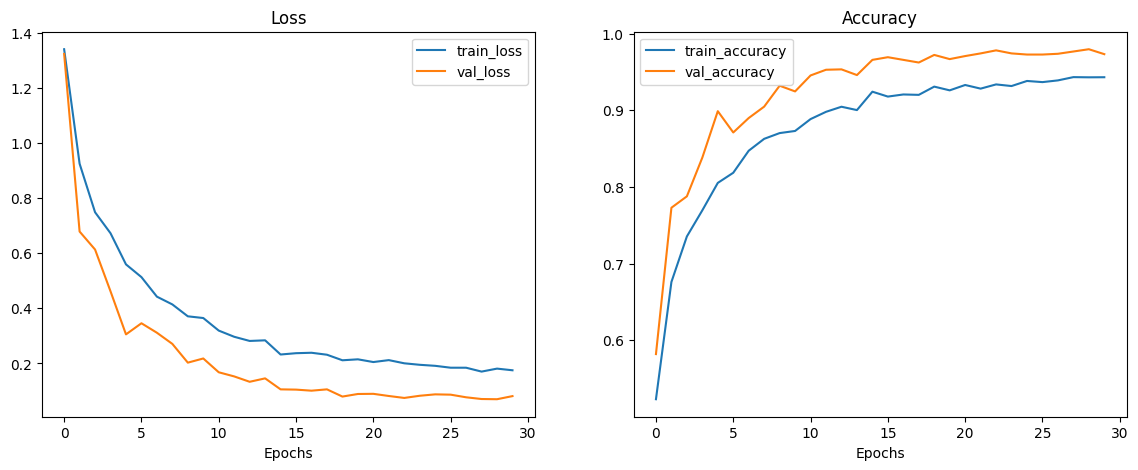

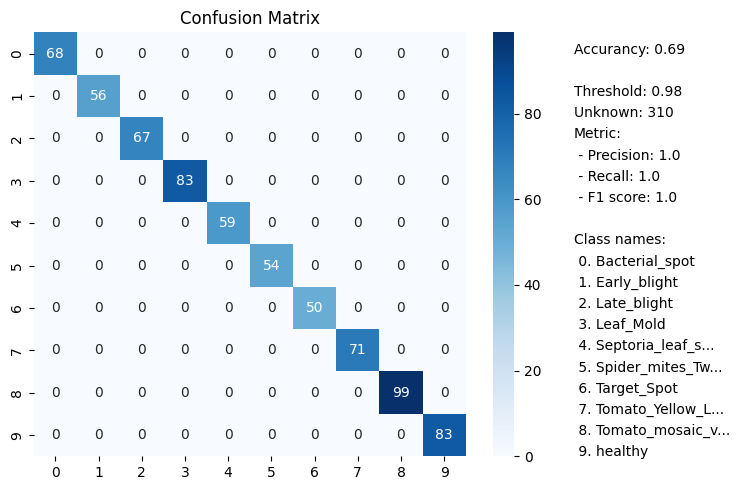

In [5]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'dataset_path':'./datasets/tomato',
            'folder_train': 'train',
            'folder_val': 'val',    
            'folder_test': 'test',
            'batch_size': 32,
        },
        'train_para': {
            'pretrain_model_path': './runs/classify/train1',
            'epochs': 0,
            'optimize' : {
                'learning_rate': 0.002,
                'momentum': 0.9,
                'weight_decay': 0.00001,
            },
            'lr_scheduler' : {
                'step_size' : 2,
                'gamma' : 0.75,
            },
            'save_checkpoint_freq' : 0,
            'verbose': True
        },
        'test_para': {
            'threshold': 0.98
        },
    }

    # train.run(**config)
    run(**config)

In [1]:
# %%writefile model/train.py
import torch
from torch import nn
from torchvision import transforms

from pathlib import Path
from torchmetrics import Accuracy, ConfusionMatrix

from model.data_setup import create_dataloader
from model.engine import train, test
from model.utils import plot_save_model
from model.model_builder import resnet50_model
from model.model_builder import resnet18_model
from model.model_builder import efficientnet_b3_model
from model.model_builder import vgg19_model

def run(**kwargs):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    print(f"Device: '{device}'")
    
    torch.cuda.empty_cache()
    
    train_transforms_data = transforms.Compose([
        transforms.RandomResizedCrop(size=(224, 224), antialias=True),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0)),
        transforms.transforms.ColorJitter(brightness= [0.9, 1.1], contrast= [0.9, 1.1]),
        transforms.ToTensor(),
        # transforms.Normalize((0.1256, 0.1557, 0.0972), (0.1881, 0.2228, 0.1511)),
    ])
    
    val_transforms_data = transforms.Compose([
        transforms.Resize(size= 224),
        transforms.ToTensor(),
        # transforms.Normalize((0.1256, 0.1557, 0.0972), (0.1881, 0.2228, 0.1511)),
    ])

    test_transforms_data = transforms.Compose([
        transforms.Resize(size= 224),
        transforms.ToTensor(),
        # transforms.Normalize((0.1256, 0.1557, 0.0972), (0.1881, 0.2228, 0.1511)),
    ])
    
    train_dataloader, val_dataloader, test_dataloader, class_names = create_dataloader(train_transform=train_transforms_data,
                                                                                      val_transform=val_transforms_data,
                                                                                      test_transform=test_transforms_data,
                                                                                      **kwargs)


    model, info_data = vgg19_model(class_names= class_names, pretrain_model_path= kwargs['train_para']['pretrain_model_path'], device= device)
    
    loss_func = nn.CrossEntropyLoss()

    lr = kwargs['train_para']['optimize']['learning_rate']
    momentum = kwargs['train_para']['optimize']['momentum']
    weight_decay = kwargs['train_para']['optimize']['weight_decay']
    optimizer = torch.optim.SGD(params= model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    
    accur = Accuracy(task='multiclass', num_classes= len(class_names)).to(device)

    step_size = kwargs['train_para']['lr_scheduler']['step_size']
    gamma = kwargs['train_para']['lr_scheduler']['gamma']
    lr_scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer,
        step_size= step_size,
        gamma= gamma
    )

    epochs= kwargs['train_para']['epochs']
    save_checkpoint_freq= kwargs['train_para']['save_checkpoint_freq']
    verbose= kwargs['train_para']['verbose']
    
    results = train(
            model= model,
            train_dataloader= train_dataloader,
            val_dataloader= val_dataloader,
            loss_func= loss_func,
            optimizer= optimizer,
            lr_scheduler= lr_scheduler,
            mectric_funcs= accur,
            epochs= epochs,
            info_data = info_data,
            save_checkpoint_freq= save_checkpoint_freq,
            verbose= verbose,
            device= device,
    )

    results = test(model=model,
                  test_dataloader=test_dataloader,
                  results=results,
                  verbose= verbose,
                  device= device)

    is_save = True if epochs > 0 else False
    plot_save_model(model= model, results= results, class_names= class_names, is_save= is_save, device= device, **kwargs)
    
    torch.cuda.empty_cache()

Device: 'cuda'


Training:   0%|          | 0/20 [00:00<?, ?it/s]



Epoch:  1 ------------


-----Train:   0%|          | 0/250 [00:16<?, ?it/s]

-------Val:   0%|          | 0/63 [00:16<?, ?it/s]

Epoch:  1 | Train Loss: 1.21811 | Train Acc: 57.0456 | Val Loss: 0.51208 | Val Acc: 82.3909


Epoch:  2 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  2 | Train Loss: 0.62721 | Train Acc: 78.3605 | Val Loss: 0.27001 | Val Acc: 90.5754


Epoch:  3 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  3 | Train Loss: 0.40876 | Train Acc: 86.6980 | Val Loss: 0.27122 | Val Acc: 90.5754


Epoch:  4 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  4 | Train Loss: 0.34726 | Train Acc: 88.4738 | Val Loss: 0.16569 | Val Acc: 94.7421


Epoch:  5 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  5 | Train Loss: 0.27975 | Train Acc: 90.1988 | Val Loss: 0.18640 | Val Acc: 92.9563


Epoch:  6 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  6 | Train Loss: 0.27282 | Train Acc: 90.6613 | Val Loss: 0.18469 | Val Acc: 93.4524


Epoch:  7 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  7 | Train Loss: 0.22716 | Train Acc: 92.2117 | Val Loss: 0.11961 | Val Acc: 95.7341


Epoch:  8 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  8 | Train Loss: 0.21028 | Train Acc: 92.5742 | Val Loss: 0.11659 | Val Acc: 96.1310


Epoch:  9 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch:  9 | Train Loss: 0.18967 | Train Acc: 93.7101 | Val Loss: 0.10986 | Val Acc: 96.2798


Epoch: 10 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 10 | Train Loss: 0.18102 | Train Acc: 93.7496 | Val Loss: 0.11377 | Val Acc: 96.0813


Epoch: 11 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 11 | Train Loss: 0.15556 | Train Acc: 94.6488 | Val Loss: 0.09566 | Val Acc: 96.8750


Epoch: 12 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 12 | Train Loss: 0.16221 | Train Acc: 94.6488 | Val Loss: 0.12857 | Val Acc: 95.8333


Epoch: 13 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 13 | Train Loss: 0.14110 | Train Acc: 95.0613 | Val Loss: 0.09724 | Val Acc: 96.6766


Epoch: 14 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 14 | Train Loss: 0.14449 | Train Acc: 95.1625 | Val Loss: 0.08445 | Val Acc: 97.1230


Epoch: 15 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 15 | Train Loss: 0.13192 | Train Acc: 95.3246 | Val Loss: 0.07980 | Val Acc: 97.2718


Epoch: 16 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 16 | Train Loss: 0.14426 | Train Acc: 95.2500 | Val Loss: 0.08757 | Val Acc: 97.0238


Epoch: 17 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 17 | Train Loss: 0.11776 | Train Acc: 95.8500 | Val Loss: 0.07923 | Val Acc: 97.5198


Epoch: 18 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 18 | Train Loss: 0.11427 | Train Acc: 96.0867 | Val Loss: 0.08121 | Val Acc: 97.3710


Epoch: 19 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 19 | Train Loss: 0.12232 | Train Acc: 95.8996 | Val Loss: 0.08134 | Val Acc: 97.6190


Epoch: 20 ------------


-----Train:   0%|          | 0/250 [00:00<?, ?it/s]

-------Val:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 20 | Train Loss: 0.11805 | Train Acc: 95.9242 | Val Loss: 0.07349 | Val Acc: 97.9167





------Test:   0%|          | 0/32 [00:00<?, ?it/s]

[INFO] Saving model to: runs\classify\train4


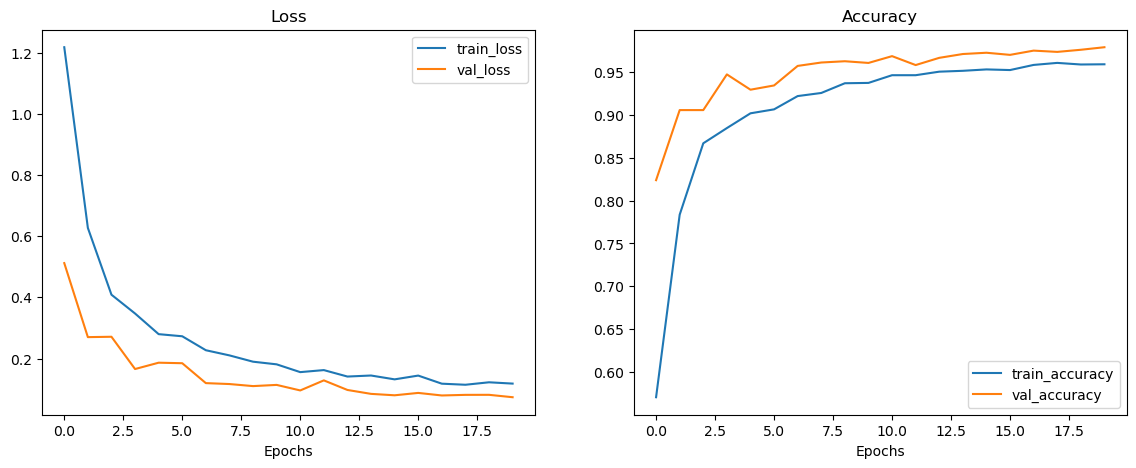

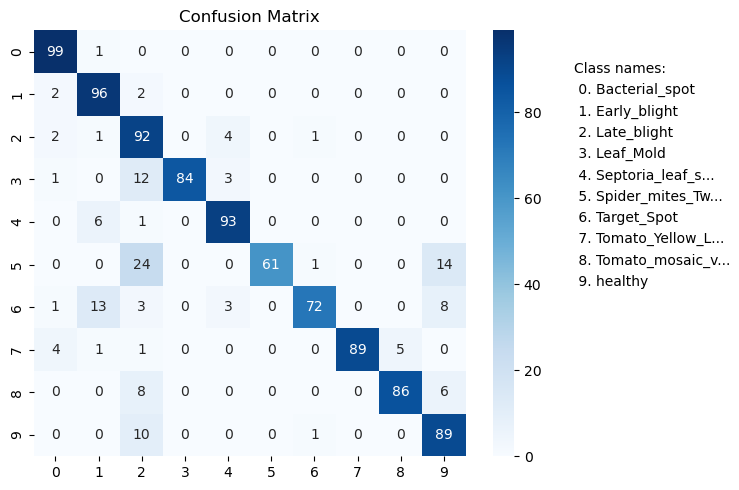

In [2]:
# from model import train

if __name__ == '__main__':
    config = {
        'dataset' : {
            'train': './datasets/tomato_rembg/train',
            'val': './datasets/tomato_rembg/val',    
            'test': './datasets/tomato_rembg/test',
            'batch_size': 32,
        },
        'model': 'vgg19',
        'train_para': {
            'pretrain_model_path': None,
            'epochs': 20,
            'optimize' : {
                'learning_rate': 0.002,
                'momentum': 0.9,
                'weight_decay': 0.00001,
            },
            'lr_scheduler' : {
                'step_size' : 2,
                'gamma' : 0.75,
            },
            'save_checkpoint_freq' : 0,
            'verbose': True
        },
        'test_para': {
            'threshold': 0.99
        },
    }

    # train.run(**config)
    run(**config)